# Solving differential equations using neural nets

Neural networks have gathered enourmous attention in the last decade. Our whole human community have been shocked with the ability to talk to ChatGPT and create convincing videos of [Taylor Swift proving that $\sqrt{2}$ is irrational](https://www.youtube.com/watch?v=meudJkjKEe8). 

[While there is deep controversy about their training schemes](https://www.reuters.com/legal/litigation/google-sued-by-us-artists-over-ai-image-generator-2024-04-29/), and [their ability to strengthen biases](https://www.nea.org/nea-today/all-news-articles/does-ai-have-bias-problem), all of that discussion overlooks the fundamental reason why neural networks work at all:  they are universal approximators. This means [they have the capacity to approximate any continuous function, given enough training and the appropriate architecture](https://en.wikipedia.org/wiki/Universal_approximation_theorem). 

For that reason, neural networks can not only reproduce patterns image, voice, and text  but also directly approximate solutions of well-posed mathematical problems. One area in which this is useful is solving differential equations. As mathematicians and scientists are aware, besides the small class of [linear differential equations](https://en.wikipedia.org/wiki/Linear_differential_equation) there is no unified theory on how to solve them. In practice we usually try to linearize the equation using techniques such as [separation of variables](https://math.libretexts.org/Courses/Monroe_Community_College/MTH_211_Calculus_II/Chapter_8%3A_Introduction_to_Differential_Equations/8.3%3A_Separable_Differential_Equations) or by guesses (or in current mathematical terminology [ansatz](https://en.wikipedia.org/wiki/Ansatz)) from which the solution can be verified. However, there is often no guarantees that it can work for an arbitrary differential equation. 

In this post, I will show how to use a neural network to solve differential equations. This framework is usually refered to as [physics informed neural networks (PINNs)](https://doi.org/10.1016/j.jcp.2018.10.045). As the main example, we will work on a classic example for many physics studies: the damped harmonic oscillator. 

While some there are good other texts giving a similar lesson, [often with the same example](https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/),  from what I have gathered, they usually assume there is some form of data the neural network is supposed to ``fit''. Here I will present a work flow where the neural network is only supposed to *only* solve the mathematics involved in the differential equation.

Before anything else, let us setup the necessary libraries, here we will use [PyTorch](https://pytorch.org/) to implement our neural network.

In [1]:
import torch
import torch.nn as nn
torch.manual_seed(42)

import matplotlib.pyplot as plt
from math import pi

## The damped harmonic oscillator and its differential equation

Suppose I have a system of a spring and a mass allowed to move on a table with friction as in the figure below:


Say the mass is moved from the spring stable position by a displacement $x_0$ and released. We want to find how the position of the mass,  $x$, evolves in time. 

Two forces act on the mass, the restoring force from the spring, usually modelled through [Hooke's law](https://en.wikipedia.org/wiki/Hooke%27s_law) as $-kx$ with the $-$ sign representing that 
the force is *opposite* to where the spring is pushed from its stable position,conventionally chosen as $x=0$. The other force is the friction oposing the movement $-\lambda \frac{\mathrm{d}x}{{\mathrm{d}t}}$. Although we refer to this as a friction force, this is *not* the [friction model usually taught in early courses in physics](https://phys.libretexts.org/Bookshelves/University_Physics/University_Physics_(OpenStax)/Book%3A_University_Physics_I_-_Mechanics_Sound_Oscillations_and_Waves_(OpenStax)/06%3A_Applications_of_Newton%27s_Laws/6.04%3A_Friction_(Part_1)) but rather more akin to [damping due to movement in a viscous fluid](https://en.wikipedia.org/wiki/Damping), with $\lambda$ beign the *viscous damping coeffient* one can think on this more like air resistence than direct friction. 

Using Newton's second law of motion, the mass times acceleration $m \frac{\mathrm{d}^2x}{{\mathrm{d}t^2}}$  is equal to the total force, allowing us to write the differential equation as 
$$ m \frac{\mathrm{d}^2x}{{\mathrm{d}t^2}} = -kx -\lambda \frac{\mathrm{d}x}{{\mathrm{d}t}} \ . \ \ \ (1) $$
with some algebraic steps we can rewrite the equation above as 
$$ \frac{\mathrm{d}^2x}{{\mathrm{d}t^2}} + \xi \frac{\mathrm{d}x}{{\mathrm{d}t}}  + \omega_0^2 x = 0 \ , \ \ \ (2) $$
with $\omega_0 = \sqrt{k/m}$ and $\xi =\lambda/m$. 



Let $t=0$ be the time at which the mass is released. Since it is released from rest we deduce that, at $t=0$ we must have 
$$ x(0) = x_0 , \ \ \text{and} \ \ \frac{\mathrm{d}x}{{\mathrm{d}t}} \Bigr|_{t=0} = 0 \ . \ \ \ (3) $$
In the language of differential equations we say this is our *initial condition*.

We say we solve the differential equation if we find $x(t)$, or the position of the mass as a function of time, that obeys both (2) and (3).

## Solving the 'underdumped' case

First let us assuma a case where $\xi < 2\omega_0$. In rough terms that means that the dumping is weaker than the . In other words, the system is undumped. The next block of code will set what the variables of the problem: $x_0, \omega_0, \text{and}, \xi$ are.

In [2]:
x0 = 1
w = 4*pi
xi = 1

### Exact solution
In order to have something to compare our solution to, let us see if there are standard ways to solve (2) in the the underdumped condition. It has been proven (see *e.g* [here](http://www.physicsbootcamp.org/Damped-Harmonic-Oscillator.html), but it can be found in virtually any physics I textbook ) that the exact solution is given by:

$$x(t) = x_0 e^{-\xi/2 t } \cos(\omega t)  \ .$$
An attemptive reader may notice through direct differentiating $x$ above that it, indeed, solves (2) and obeys (3). In the process they will notice how labourious is to verify that ansatz, let alone come up with them. However we can intuit on its meaning. The solution is an oscillation, represented by the $\cos(\omega t)$ term, and the oscilating amplitude decays exponentially $x_0 e^{-\xi/2 t }$. This can be directly seen in the graph below

Text(0, 0.5, 'Position')

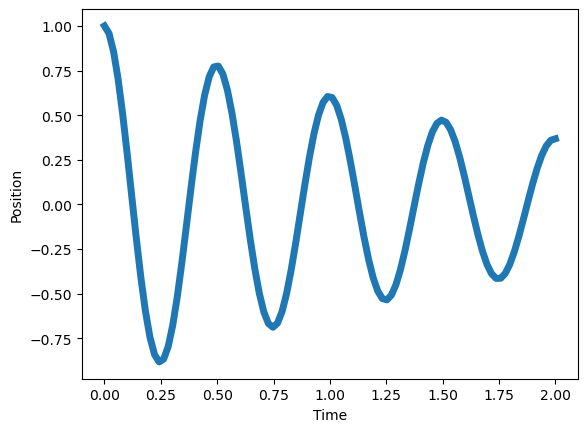

In [3]:
t = torch.linspace(0, 2, 100)[:, None]
x_sol = lambda t: x0*torch.exp(-.5*xi*t)*torch.cos(w*t)
plt.plot(t.numpy(),x_sol(t),linewidth=5)
plt.xlabel('Time')
plt.ylabel('Position')

### Solving with neural network

If we want to solve the problem with neural networks, we need to start by defining our neural architecture. The goal is to use the neural network to creat a single-value function of time, $t$, which we refer to as $\mathcal{N}(t)$ and use it to generate $x(t)$. Thus our architecture needs to map a single feature into (another) single feature but still have the necessary complexity to fit a complicated function.  For this post we will use a sequential model composed of four [linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layers. The architecture maps from 1 to 64 features, then from 64 to 256 features, followed by 256 to 64 features, and finally from 64 to 1 feature, with [GELU](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) activation.

In [4]:
architecture = lambda: nn.Sequential(nn.Linear(1, 64), nn.GELU(),
                                     nn.Linear(64, 256), nn.GELU(),
                                     nn.Linear(256, 64), nn.GELU(),
                                     nn.Linear(64,1, bias=False))

N = architecture()

Now, as it is often the case with neural networks, it may be challenging to interpret what the neural network internal parameters do to solve the problem as a whole. Besides the architecture selection we have little control over what $\mathcal{N}(t)$ is initially. The goal, then becomes to train the neural network to solve our differential equation (2) while obeying the initial condition (3). 

In order to do so, it is useful to define the following function
$$ \tilde{x}(t) \equiv x_0 + \mathcal{N}(t)  t^2 \ , $$
with te simbol $\equiv$ meaning ``defined as equal to''.

In [5]:
x_t = lambda t,N: x0+N(t)*(t**2)

Note that *by definition* we have $\tilde{x}(t)=x_0$ and $\frac{\mathrm{d}x}{{\mathrm{d}t}}\Bigr|_{t=0} = 0$ obeying the initial condition (3) no matter what the network is. The goal, then, becomes to train the neural network (change $\mathcal{N}$) so that  $ \tilde{x}(t)$ approximates the solution of the differential equation (2).

So, in order to train the neural network we ought to define a loss function to later be minimized. If $\tilde{x}(t)$ is to approximate the solution of (2) we must have 
$$ \frac{\mathrm{d}^2 \tilde{x} }{{\mathrm{d}t^2}} + \xi \frac{\mathrm{d}\tilde{x} }{{\mathrm{d}t}}  + \omega_0^2 \tilde{x} \approx 0 \ . \ \ \ (4) $$
at every time $t$. 

While it is hard to guarantee that the approximation above holds across a continuous, let us create an array of "test" times `t` of 500 points from $t=0$ to $t=2$.

In [6]:
t = torch.linspace(0, 2, 500).reshape(-1,1)

Thus, within the interval $t \in [0,2]$ we replace the approximation (4), taken for continuous time $t$, by the discrete version 
$$  \sum_{k=0}^K \left [ \frac{\mathrm{d}^2 \tilde{x}  }{{\mathrm{d}t^2}} \Bigr|_{t=t_k}+ \xi \frac{\mathrm{d}\tilde{x}}{{\mathrm{d}t}}\Bigr|_{t=t_k} + \omega_0^2 \tilde{x} \right] \approx 0\ ,  $$
with $t_k$ being the elements in the array `t`, and K being its total size. 

For that, let us define the *loss function* $\mathcal{L}$ as 
$$ \mathcal{L}(\mathcal{N})  \equiv \frac{1}{K}  \sum_{k=0}^K  \left[ \frac{\mathrm{d}^2 \tilde{x}  }{{\mathrm{d}t^2}} \Bigr|_{t=t_k}+ \xi \frac{\mathrm{d}\tilde{x}}{{\mathrm{d}t}}\Bigr|_{t=t_k} + \omega_0^2 \tilde{x} \right]^2 \ . \ \ \ (5) $$
While calculating the derivatives of $\tilde{x}$ can sound like a challengin task, neural network libraries [usually contain tools to automatically calculate derivatives of a function](https://labpresse.com/what-is-autograd-automatic-differentiation-and-optimization-with-pytorch/). Here we use PyTorch's `autograd` tool

In [7]:
def loss(t,N):
    t.requires_grad = True
    x = x_t(t,N)
    dxdt = torch.autograd.grad(x,t, torch.ones_like(t), create_graph=True)[0]
    d2xdt2 = torch.autograd.grad(dxdt,t, torch.ones_like(t), create_graph=True)[0]
    loss_ode = d2xdt2 + xi*dxdt +(w**2)*x
    return torch.mean(torch.pow(loss_ode,2))

Note that $\mathcal{L}$ is *strictly* non-negative (it is a sum of squared terms, which are non-negative), therefore its minumum possible value is 0.

We then traing the network, meaning change $\mathcal{N}$ so that $\mathcal{L}(\mathcal{N})$ takes smaller values, and say we are done training when the loss function is smaller than some threshold value (we use .1). This is done by the following block of code

In [8]:
optimizer = torch.optim.Adam(N.parameters())

l = loss(t,N)
i=0

while l.item()>.1:
    optimizer.zero_grad()
    l = loss(t,N)
    l.backward()
    optimizer.step()

    ## Took around 1.5 mins in my machine

While it is not our goal to fully describe the training of neural networks, it is relevant to delve further into what the previous block of code does. In short, the neural network architecture can generate a whole class of functions by adjusting its internal parameters. In this case, it identifies the function $\mathcal{N}$, among the ones that can be generated by the architecture, that minimizes $\mathcal{L}$.

We can now visualize the results of our neural network solution by compare to the known exact solution of the underdamped oscilator.

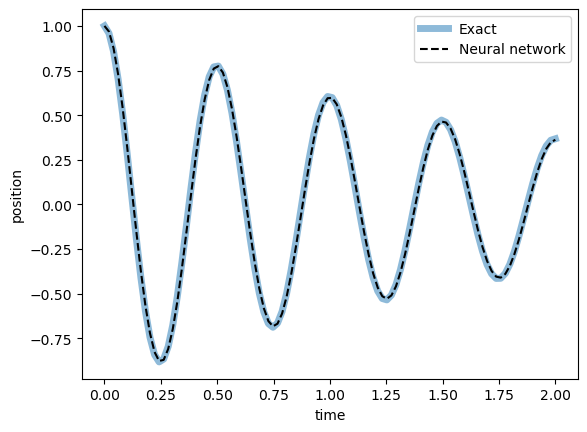

In [9]:
tt = torch.linspace(0, 2., 100).unsqueeze(1)
with torch.no_grad():
    xx = x_t(torch.Tensor(tt),N).numpy() #Neural
xt = x_sol(tt) #Analitic

fig, ax = plt.subplots(dpi=100)
ax.plot(tt, xt, label='Exact', linewidth=5,alpha=.5)
ax.plot(tt, xx, '--', label='Neural network',color='k')
ax.set_xlabel('time')
ax.set_ylabel('position')
plt.legend()
#plt.savefig('Rightfit_{}.png'.format(np.random.randint(100)))

Now, as good as the result may look, so far we have only dealt with the underdumped case $\xi < 2\omega_0$. But the solution method here can, indeed be extended generally, as we will observe below.

## Critically dumped

In [10]:
w_critical = 4*pi
xi_critical = w_critical*2

In [11]:
N_critical = architecture()

def loss_critical(t,N):
    t.requires_grad = True
    x = x_t(t,N)
    dxdt = torch.autograd.grad(x,t, torch.ones_like(t), create_graph=True)[0]
    d2xdt2 = torch.autograd.grad(dxdt,t, torch.ones_like(t), create_graph=True)[0]
    loss_ode = d2xdt2 + xi_critical*dxdt +(w_critical**2)*x
    return torch.mean(torch.pow(loss_ode,2))

In [12]:
optimizer_critical = torch.optim.Adam(N_critical.parameters())

l = loss_critical(t,N_critical)
i=0

while l.item()>.1:
    optimizer_critical.zero_grad()
    l = loss_critical(t,N_critical)
    l.backward()
    optimizer_critical.step()

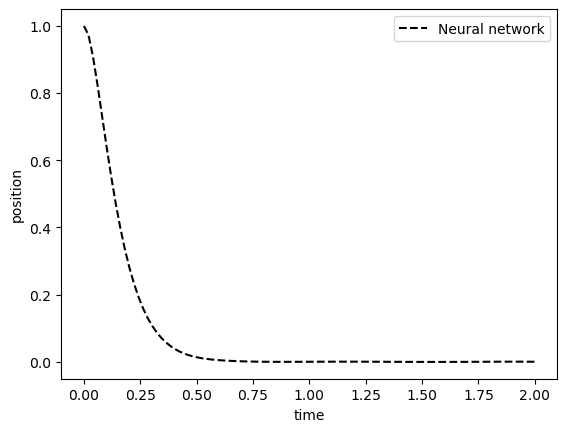

In [13]:
tt = torch.linspace(0, 2., 100).unsqueeze(1)
with torch.no_grad():
    xx = x_t(torch.Tensor(tt),N_critical).numpy() #Neural
#xt = x_sol(tt) #Analitic

fig, ax = plt.subplots(dpi=100)
#ax.plot(tt, xt, label='Exact', linewidth=5,alpha=.5)
ax.plot(tt, xx, '--', label='Neural network',color='k')
ax.set_xlabel('time')
ax.set_ylabel('position')
plt.legend()
#plt.savefig('Rightfit_{}.png'.format(np.random.randint(100)))

In [14]:
x_sol_critical = lambda t:  x0*torch.exp(-.5*xi_critical*t)*(1+.5*xi_critical*t)

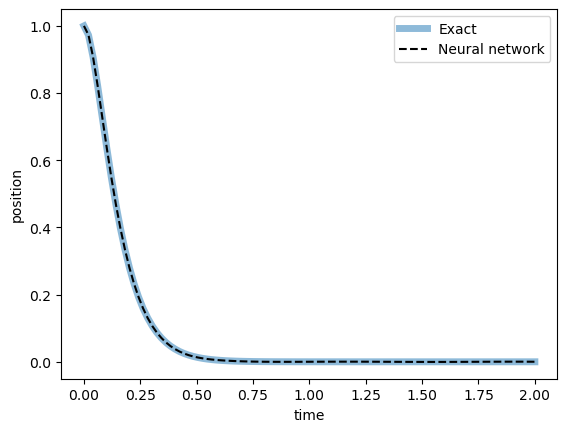

In [15]:
tt = torch.linspace(0, 2., 100).unsqueeze(1)
with torch.no_grad():
    xx = x_t(torch.Tensor(tt),N_critical).numpy() #Neural
xt = x_sol_critical(tt) #Analitic

fig, ax = plt.subplots(dpi=100)
ax.plot(tt, xt, label='Exact', linewidth=5,alpha=.5)
ax.plot(tt, xx, '--', label='Neural network',color='k')
ax.set_xlabel('time')
ax.set_ylabel('position')
plt.legend()
#plt.savefig('Rightfit_{}.png'.format(np.random.randint(100)))

## overdumped

In [16]:
w_over = 4*pi
xi_over = w_over*3

In [17]:
N_over = architecture()


def loss_over(t,N):
    t.requires_grad = True
    x = x_t(t,N)
    dxdt = torch.autograd.grad(x,t, torch.ones_like(t), create_graph=True)[0]
    d2xdt2 = torch.autograd.grad(dxdt,t, torch.ones_like(t), create_graph=True)[0]
    loss_ode = d2xdt2 + xi_over*dxdt +(w_over**2)*x
    return torch.mean(torch.pow(loss_ode,2))

In [18]:
optimizer_over = torch.optim.Adam(N_over.parameters())

l = loss_over(t,N_over)
i=0

while l.item()>.1:
    optimizer_over.zero_grad()
    l = loss_over(t,N_over)
    l.backward()
    optimizer_over.step()

    #i+=1
    #if i%100==0:
    #    print(i,l.item())
    ## Took around 1 min in my machine

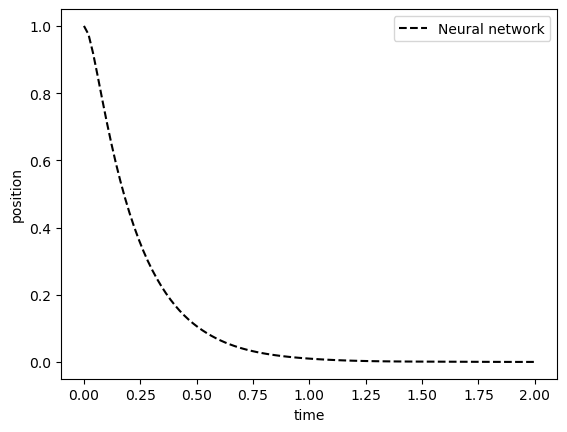

In [19]:
tt = torch.linspace(0, 2, 100).unsqueeze(1)
with torch.no_grad():
    xx = x_t(torch.Tensor(tt),N_over).numpy() #Neural
#xt = x_sol(tt) #Analitic

fig, ax = plt.subplots(dpi=100)
#ax.plot(tt, xt, label='Exact', linewidth=5,alpha=.5)
ax.plot(tt, xx, '--', label='Neural network',color='k')
#ax.plot(tt,x_t(tt,N_critical).detach().numpy())
ax.set_xlabel('time')
ax.set_ylabel('position')
plt.legend()
#plt.savefig('Rightfit_{}.png'.format(np.random.randint(100)))

In [20]:
x_sol_over = lambda t:  x0*torch.exp(-.5*xi_over*t)*(torch.exp(w_over*t)+torch.exp(-w_over*t))/2

c1,c2 = (1+xi_over/(2*w_over))*x0/2, (1-xi_over/(2*w_over))*x0/2
b = torch.sqrt(torch.tensor(xi_over**2/4 - w_over**2))
x_sol_over = lambda t:  x0*torch.exp(-.5*xi_over*t)*(c1*torch.exp(b*t)+c2*torch.exp(-b*t))

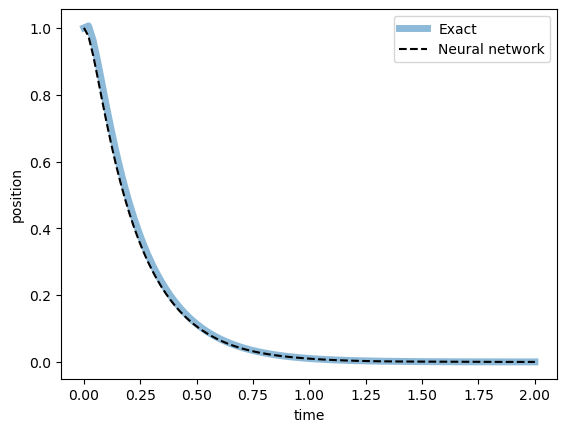

In [21]:
tt = torch.linspace(0, 2, 100).unsqueeze(1)
with torch.no_grad():
    xx = x_t(torch.Tensor(tt),N_over).numpy() #Neural
xt = x_sol_over(tt) #Analitic

fig, ax = plt.subplots(dpi=100)
ax.plot(tt, xt, label='Exact', linewidth=5,alpha=.5)
ax.plot(tt, xx, '--', label='Neural network',color='k')
ax.set_xlabel('time')
ax.set_ylabel('position')
plt.legend()
#plt.savefig('Rightfit_{}.png'.format(np.random.randint(100)))

## When the neural network does not work

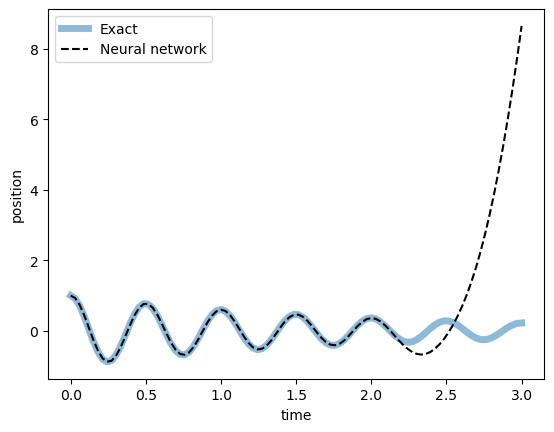

In [22]:
tt = torch.linspace(0, 3., 100).unsqueeze(1)
with torch.no_grad():
    xx = x_t(torch.Tensor(tt),N).numpy() 
xt = x_sol(tt) 


fig, ax = plt.subplots(dpi=100)
ax.plot(tt, xt, label='Exact', linewidth=5,alpha=.5)
ax.plot(tt, xx, '--', label='Neural network',color='k')
ax.set_xlabel('time')
ax.set_ylabel('position')
plt.legend()
#plt.savefig('Rightfit_{}.png'.format(np.random.randint(100)))